# Import qbiome

In [1]:
import qbiome
from qbiome.data_formatter import DataFormatter
from qbiome.quantizer import Quantizer
from qbiome.qnet_orchestrator import QnetOrchestrator
from qbiome.mask_checker import MaskChecker
from qbiome.forecaster import Forecaster
from qbiome.hypothesis import Hypothesis

# Import other packages

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
plt.style.use('ggplot')

# Data

In [3]:
dirname = 'example_data/'
data = dirname + 'SamplesByMetadata_otuDADA2_EMP_10249_ECAM_RSRC_TaxaRelativeAbundance.csv'
meta = dirname + 'SamplesByMetadata_otuDADA2_EMP_10249_ECAM_RSRC_Characteristics.csv'

# Instantiate the data formatter, quantizer, qnet orchestrator

In [4]:
formatter = DataFormatter()
quantizer = Quantizer()
qnet_orchestrator = QnetOrchestrator(quantizer)

# Load, quantize, and convert the data to qnet input format

In [5]:
data = formatter.load_data(data, meta)
quantized = quantizer.quantize_df(data)
features, label_matrix = quantizer.get_qnet_inputs(quantized)

There are 29 unique biomes and 1216 unique samples
There are 311 unique days
There are 99 unique weeks


In [6]:
len(features)

621

# Train qnet

In [7]:
# should take < 5 min to run
qnet_orchestrator.train_qnet(
    features, label_matrix, alpha=0.2, min_samples_split=2, 
    out_fname='biome_net.joblib')

# Use the mask checker to mask 20% of the label matrix and use qnet to predict

In [8]:
mask_checker = MaskChecker(qnet_orchestrator)

In [9]:
# takes 2 minutes to run
predicted = mask_checker.mask_and_predict(label_matrix, mask_percent=20)

In [10]:
predicted.head()

,subject_id,variable,week,value
0,1,Acidobacteriota,1,0.004063
1,10,Acidobacteriota,1,0.004063
2,11,Acidobacteriota,1,0.003936
3,12,Acidobacteriota,1,0.003999
4,14,Acidobacteriota,1,0.004126


# Plot the predicted vs. original biome measurements

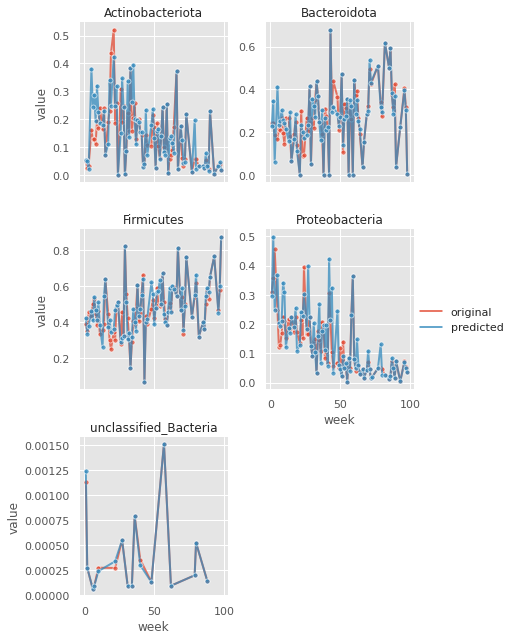

In [11]:
BIOMES = ['Actinobacteriota', 'Bacteroidota', 'Firmicutes', 'Proteobacteria', 'unclassified_Bacteria']

concat = pd.concat([
    data.assign(source='original'), 
    predicted.assign(source='predicted')
])
concat = concat[concat.variable.isin(BIOMES)]

g = sns.FacetGrid(concat, col='variable', col_wrap=2, sharey=False, margin_titles=True)
g.map_dataframe(sns.lineplot, 'week', 'value', hue='source', ci=None, marker='o',
                    linewidth=2, alpha=0.75, markersize=5)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.add_legend()

It appears that the prediction passes our eyeball sanity check.

We zoom in to look at the first 20 weeks.

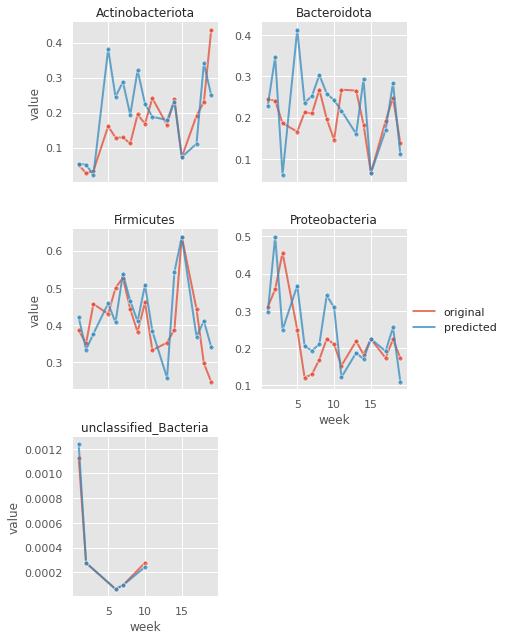

In [12]:
concat = concat[(concat.week <= 20)]

g = sns.FacetGrid(concat, col='variable', col_wrap=2, sharey=False, margin_titles=True)
g.map_dataframe(sns.lineplot, 'week', 'value', hue='source', ci=None, marker='o',
                    linewidth=2, alpha=0.75, markersize=5)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.add_legend()

To increase the precision of the prediction, we can apply the random forest regressor in the quantizer. See the example below when we use the forecaster.

# Use the forecaster to sequentially mask part of the original data and predict

In [13]:
forecaster = Forecaster(qnet_orchestrator)

In [14]:
# takes 10 minutes to run
# can specify an end week or default to the max end week in the data
forecasted = forecaster.forecast_data(
    label_matrix, 
    start_week=10,
#     end_week=data.week.max()
)

In [15]:
forecasted.head()

,subject_id,variable,week,value
0,1,Acidobacteriota,1,NaN
1,10,Acidobacteriota,1,NaN
2,11,Acidobacteriota,1,NaN
3,12,Acidobacteriota,1,NaN
4,14,Acidobacteriota,1,NaN


## Apply the random forest regressor in the quantizer

In [16]:
dequantized = quantizer.dequantize_to_df(label_matrix)
dequantized_plot = quantizer.melt_into_plot_format(dequantized)
quantizer.fit_random_forest(data, dequantized_plot)

In [17]:
avg_forecasted_regressed = quantizer.apply_random_forest_regressor(
    forecasted)

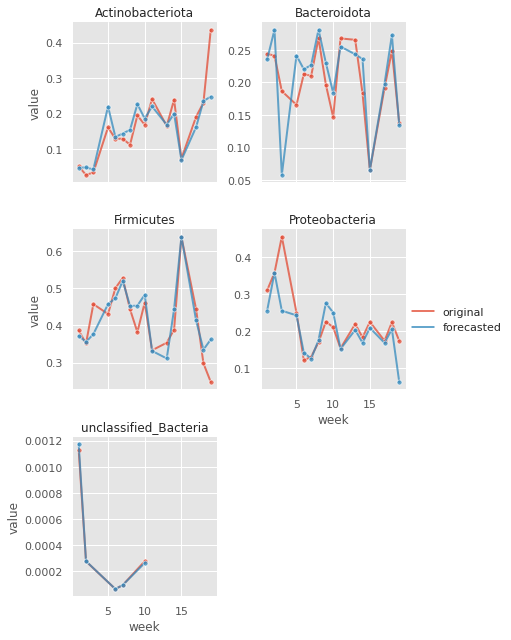

In [18]:
concat = pd.concat([
    data.assign(source='original'), 
    avg_forecasted_regressed.assign(source='forecasted')
])
concat = concat[concat.variable.isin(BIOMES)]
concat = concat[(concat.week <= 20)]

g = sns.FacetGrid(concat, col='variable', col_wrap=2, sharey=False, margin_titles=True)
g.map_dataframe(sns.lineplot, 'week', 'value', hue='source', ci=None, marker='o',
                    linewidth=2, alpha=0.75, markersize=5)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.add_legend()

# Use the forecaster to predict new data

We construct a new patient from the quantized data column names because it contains all the feature names that the qnet uses.

In [46]:
new_subject_id = '101'
np.random.seed(10001)
# initialize with random floats
new_patient = pd.DataFrame(
    np.random.rand(1, len(quantized.columns)),
    index=[0],
    columns=quantized.columns
)
new_patient.subject_id = new_subject_id
new_patient

,subject_id,Acidobacteriota_1,Acidobacteriota_9,Acidobacteriota_27,Acidobacteriota_31,Acidobacteriota_35,Actinobacteriota_1,Actinobacteriota_2,Actinobacteriota_3,Actinobacteriota_5,...,unclassified_Bacteria_31,unclassified_Bacteria_34,unclassified_Bacteria_36,unclassified_Bacteria_40,unclassified_Bacteria_48,unclassified_Bacteria_57,unclassified_Bacteria_62,unclassified_Bacteria_79,unclassified_Bacteria_80,unclassified_Bacteria_88
0,101,0.116507,0.704285,0.523539,0.1577,0.892232,0.694006,0.900454,0.584406,0.305097,...,0.239637,0.825562,0.939729,0.578875,0.484971,0.589187,0.837231,0.764129,0.080099,0.273105


In [47]:
new_patient_seq = new_patient.drop(columns='subject_id').to_numpy().squeeze()
new_patient_seq.shape

(621,)

In [48]:
# suppose we only have 6 weeks of data for the new patient
# we mask out the remainder of the weeks
new_patient_masked = qnet_orchestrator.mask_sequence_at_weeks(
    new_patient_seq, 
    start_week=7, 
    end_week=qnet_orchestrator.get_max_timestamp(),
    fill_value=np.nan
)

In [49]:
new_patient_df = quantizer.add_meta_to_matrix(
    new_patient_masked[np.newaxis, :],
    add_subject_id=False
)
# manually add back subject_id
new_patient_df.insert(0, 'subject_id', [new_subject_id])
new_patient_df

variable,subject_id,Acidobacteriota_1,Acidobacteriota_27,Acidobacteriota_31,Acidobacteriota_35,Acidobacteriota_9,Actinobacteriota_1,Actinobacteriota_10,Actinobacteriota_11,Actinobacteriota_13,...,unclassified_Bacteria_36,unclassified_Bacteria_40,unclassified_Bacteria_48,unclassified_Bacteria_57,unclassified_Bacteria_6,unclassified_Bacteria_62,unclassified_Bacteria_7,unclassified_Bacteria_79,unclassified_Bacteria_80,unclassified_Bacteria_88
0,101,0.116507,NaN,NaN,NaN,NaN,0.694006,0.900454,0.584406,0.305097,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
new_patient_df = quantizer.melt_into_plot_format(new_patient_df)
new_patient_df

,subject_id,variable,week,value
0,101,Acidobacteriota,1,0.116507
1,101,Acidobacteriota,27,NaN
2,101,Acidobacteriota,31,NaN
3,101,Acidobacteriota,35,NaN
4,101,Acidobacteriota,9,NaN
...,...,...,...,...
616,101,unclassified_Bacteria,62,NaN
617,101,unclassified_Bacteria,7,NaN
618,101,unclassified_Bacteria,79,NaN
619,101,unclassified_Bacteria,80,NaN


In [51]:
# quantize
new_patient_quantized = quantizer.quantize_df(new_patient_df)
# convert this patient into a format acceptable by the qnet
_, new_patient_matrix = quantizer.get_qnet_inputs(new_patient_quantized)
new_patient_matrix.shape

(1, 621)

## Forecast the data starting from week 7 to the last week

In [52]:
# takes 2 minutes to run
new_patient_forecasted = forecaster.forecast_data(
    new_patient_matrix, 
    start_week=7
)

In [53]:
new_patient_forecasted.head()

,subject_id,variable,week,value
0,101,Acidobacteriota,1,NaN
1,101,Acidobacteriota,27,0.002400
2,101,Acidobacteriota,31,0.000191
3,101,Acidobacteriota,35,0.000525
4,101,Acidobacteriota,9,0.000319


The NaNs are due to the random values we generated falling outside the quantization range.

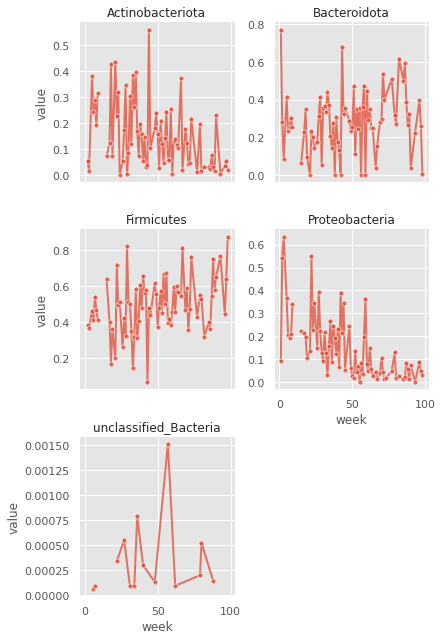

In [54]:
plottable = new_patient_forecasted[new_patient_forecasted.variable.isin(BIOMES)]

g = sns.FacetGrid(plottable, col='variable', col_wrap=2, sharey=False, margin_titles=True)
g.map_dataframe(sns.lineplot, 'week', 'value', ci=None, marker='o',
                    linewidth=2, alpha=0.75, markersize=5)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.add_legend()

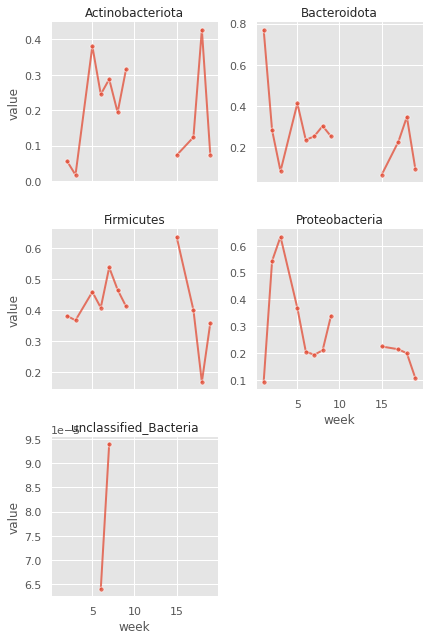

In [55]:
# zoom into the first 20 weeks
plottable = new_patient_forecasted[
    (new_patient_forecasted.variable.isin(BIOMES)) &
    (new_patient_forecasted.week <= 20)
     ]

g = sns.FacetGrid(plottable, col='variable', col_wrap=2, sharey=False, margin_titles=True)
g.map_dataframe(sns.lineplot, 'week', 'value', ci=None, marker='o',
                    linewidth=2, alpha=0.75, markersize=5)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.add_legend()